In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Затем загружаем данные (взяты отсюда https://download.pytorch.org/tutorial/hymenoptera_data.zip)

batch_size = 10

# Так как сеть, которую мы планируем взять за базу натренирована на изображениях
# определенного размера, то наши изображения необходимо к ним преобразовать
data_transforms = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225] )
    ])

# загрузим отдельно обучающий набор
train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Глубокое обучение/Animals/animals/train',
                                              transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                    shuffle=True,  num_workers=2)

class_names = train_dataset.classes

In [15]:
test_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Глубокое обучение/Animals/animals/val',
                                             transform=data_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                    shuffle=True, num_workers=2)

In [16]:
inputs, classes = next(iter(train_loader))
inputs.shape

torch.Size([10, 3, 224, 224])

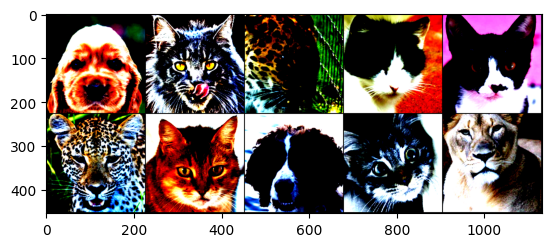

In [17]:
img = torchvision.utils.make_grid(inputs, nrow = 5) # метод делает сетку из картинок
img = img.numpy().transpose((1, 2, 0)) # транспонируем для отображения в картинке
plt.imshow(img)

In [18]:
net = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 119MB/s]


In [21]:
for param in net.parameters():
    param.requires_grad = False

# так как выходной слой AlexNet содержит 1000 нейронов (по количеству классов в ImageNet)
# то нам нужно его заменить на слой, содержащий только 2 класса

num_classes = 3

new_classifier = net.classifier[:-1] # берем все слой классификатора кроме последнего
new_classifier.add_module('fc',nn.Linear(4096,num_classes))# добавляем последним стоем новый
net.classifier = new_classifier # меняем классификатор сети

net = net.to(device)

In [22]:
correct_predictions = 0
num_test_samples = len(test_dataset)

with torch.no_grad(): # отключим вычисление граиентов, т.к. будем делать только прямой проход
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = net(images) # делаем предсказание по пакету
        _, pred_class = torch.max(pred.data, 1) # выбираем класс с максимальной оценкой
        correct_predictions += (pred_class == labels).sum().item()

print('Точность модели: ' + str(100 * correct_predictions / num_test_samples) + '%')

Точность модели: 27.066666666666666%


In [23]:
num_epochs = 2
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# создаем цикл обучения и замеряем время его выполнения
import time
t = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # прямой проход
        outputs = net(images)
        # вычисление значения функции потерь
        loss = lossFn(outputs, labels)
         # Обратный проход (вычисляем градиенты)
        optimizer.zero_grad()
        loss.backward()
        # делаем шаг оптимизации весов
        optimizer.step()
        # выводим немного диагностической информации
        if i%100==0:
            print('Эпоха ' + str(epoch) + ' из ' + str(num_epochs) + ' Шаг ' +
                  str(i) + ' Ошибка: ', loss.item())

print(time.time() - t)

Эпоха 0 из 2 Шаг 0 Ошибка:  2.56643009185791
Эпоха 0 из 2 Шаг 100 Ошибка:  0.00011897161311935633
Эпоха 0 из 2 Шаг 200 Ошибка:  0.007800665684044361
Эпоха 0 из 2 Шаг 300 Ошибка:  7.271742674674897e-07
Эпоха 0 из 2 Шаг 400 Ошибка:  0.1373560130596161
Эпоха 0 из 2 Шаг 500 Ошибка:  0.04184545949101448


KeyboardInterrupt: 

In [24]:
# Еще раз посчитаем точность нашей модели
correct_predictions = 0
num_test_samples = len(test_dataset)

with torch.no_grad(): # отключим вычисление граиентов, т.к. будем делать только прямой проход
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = net(images) # делаем предсказание по пакету
        _, pred_class = torch.max(pred.data, 1) # выбираем класс с максимальной оценкой
        correct_predictions += (pred_class == labels).sum().item()

print('Точность модели: ' + str(100 * correct_predictions / num_test_samples) + '%')
# уже лучше

Точность модели: 98.06666666666666%


In [30]:
del zip

In [31]:
from zipfile import ZipFile as zipfile

inputs, classes = next(iter(test_loader))
pred = net(inputs.to(device))
_, pred_class = torch.max(pred.data, 1)

for (i,j) in zip(inputs, pred_class):
    img = i.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(class_names[j])
    plt.pause(2)

Output hidden; open in https://colab.research.google.com to view.